In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import Data_for_bp as dfb

In [2]:
df = pd.read_pickle('Data for Practicum 2/ticks_2019.pkl')

In [3]:
time_deltas = df.index.to_series().diff()

In [4]:
def tick_data_describe(df):
    time_deltas = df.index.to_series().diff()
    summary_data = {
        'Description': [
            'Number of ticks',
            'Mean time between ticks',
            'Median time between ticks',
            'Max time between ticks',
            'Min time between ticks',
            'Ticks with time delta > 10 minutes',
            'Ticks with time delta > 60 seconds',
            'Ticks with time delta > 1 second',
            'Ticks with time delta > 0.1 seconds',
            'Ticks with time delta < 0.1 seconds'
        ],
        'Value': [
            len(df),
            time_deltas.mean(),
            time_deltas.median(),
            time_deltas.max(),
            time_deltas.min(),
            len(time_deltas[time_deltas > pd.Timedelta(minutes=10)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=60)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=1)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=0.1)]),
            len(time_deltas[time_deltas < pd.Timedelta(seconds=0.1)])
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    fig, ax = plt.subplots(figsize=(10, 3))  # set the size
    ax.axis('off')
    ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc = 'center',loc='center')
    plt.show()


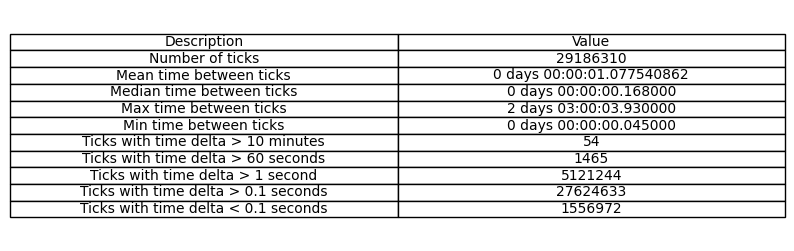

In [5]:
tick_data_describe(df)

In [6]:
ohlc = dfb.tick_to_ohlc(df, '1D')

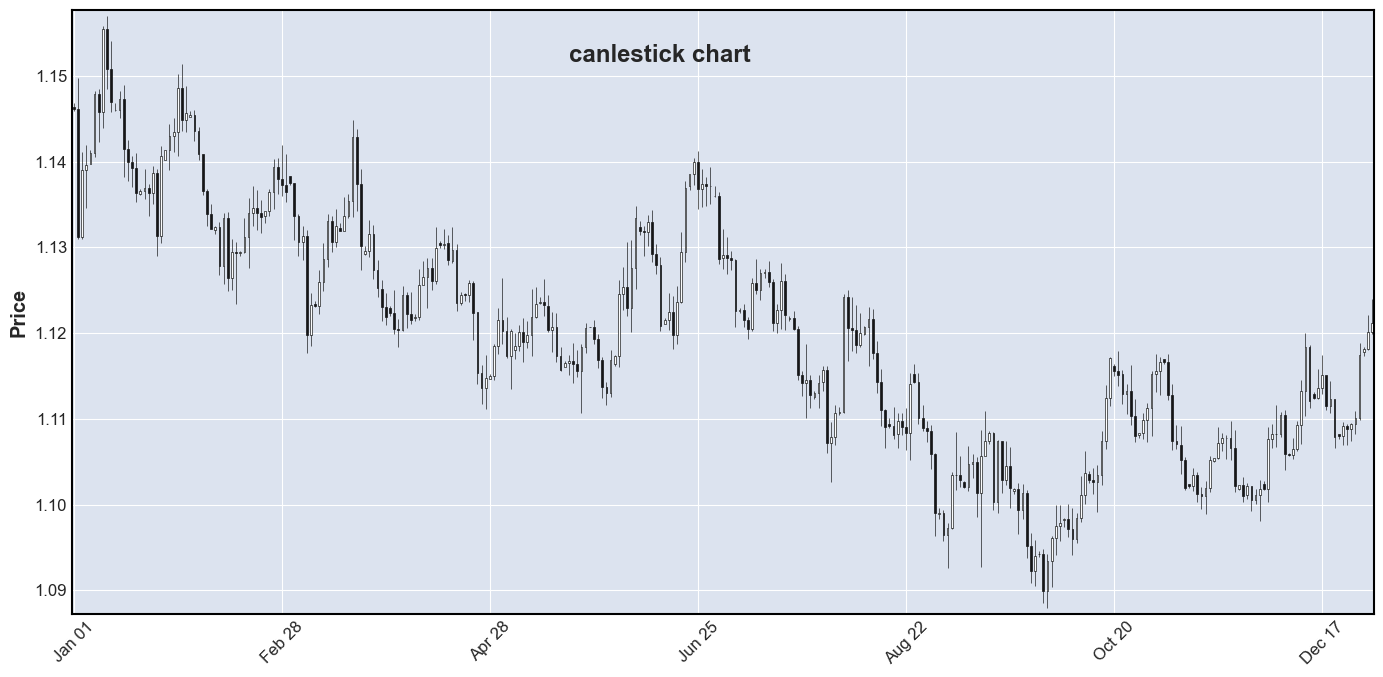

In [7]:
dfb.plot_data(ohlc)

In [8]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    daily_volatility = ohlc['returns'].std()
    buy_and_hold_return = (ohlc['returns']+1).prod()
    mean_return = ohlc['returns'].mean()
    

In [9]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    fig,axs = plt.subplots(3,1,figsize=(10,10))
    axs[0].plot(ohlc['returns'])
    axs[1].hist(ohlc['returns'],bins=20)

    daily_volatility = ohlc['returns'].std()*np.sqrt(252)*100
    buy_and_hold_return = ((ohlc['returns']+1).prod() - 1)*100  # Adjusting to get the total return
    mean_return = ohlc['returns'].mean()*100

    stats_data = {
        'Description': [
            'Daily Volatility',
            'Buy and Hold Return',
            'Mean Return'
        ],
        'Value': [
            daily_volatility,
            buy_and_hold_return,
            mean_return
        ]
    }
    
    stats_df = pd.DataFrame(stats_data)
    axs[2].axis('off')
    axs[2].table(cellText=stats_df.values, colLabels=stats_df.columns, cellLoc = 'center',loc='center')
    fig.tight_layout()
    plt.show()


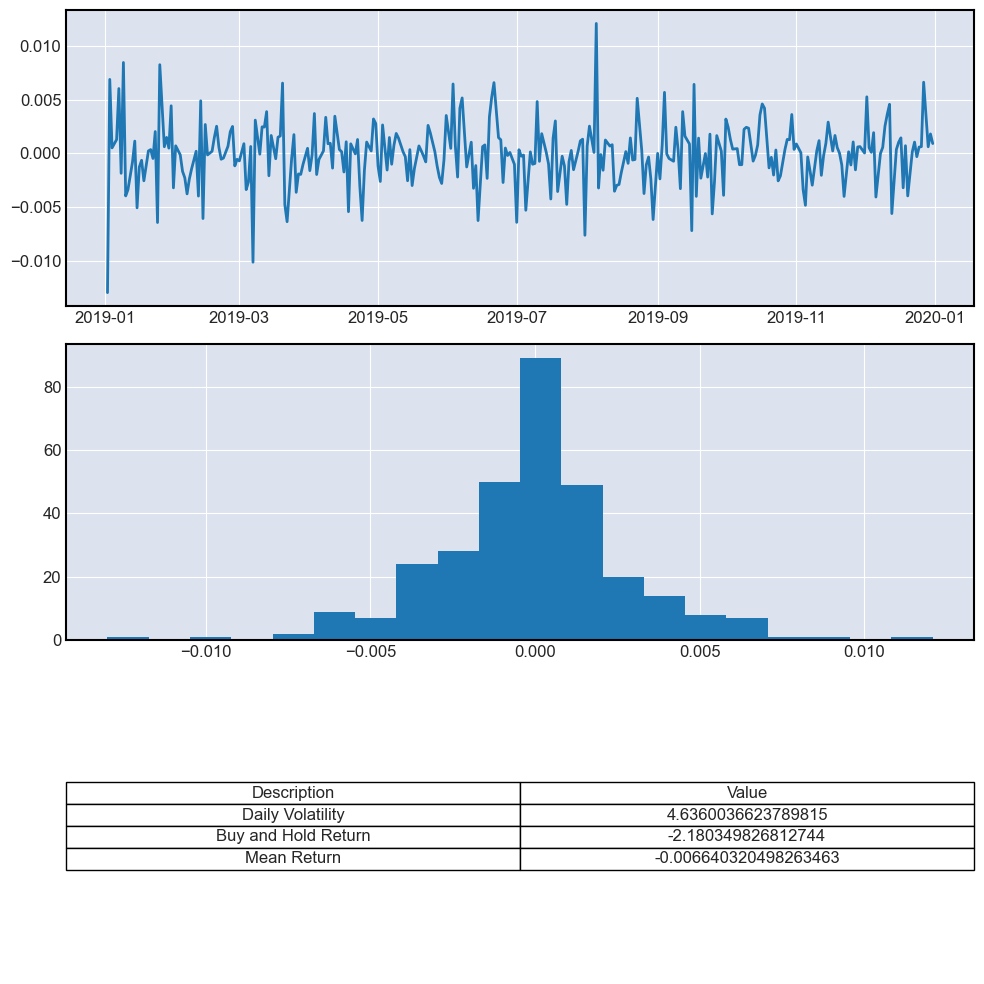

In [10]:
ohlc_stats(ohlc)

In [11]:
def data_analysis_for_bp(tick_data_file):
    df = pd.read_pickle(tick_data_file)
    tick_data_describe(df)
    ohlc = dfb.tick_to_ohlc(df, '1D')
    dfb.plot_data(ohlc)
    ohlc_stats(ohlc)

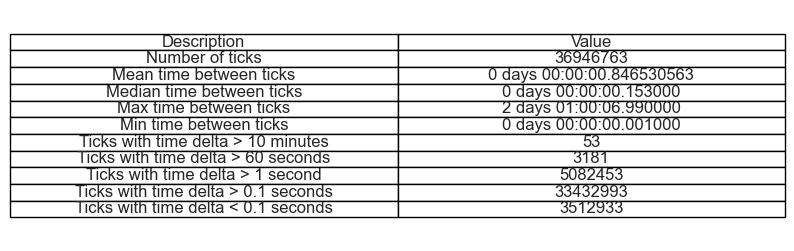

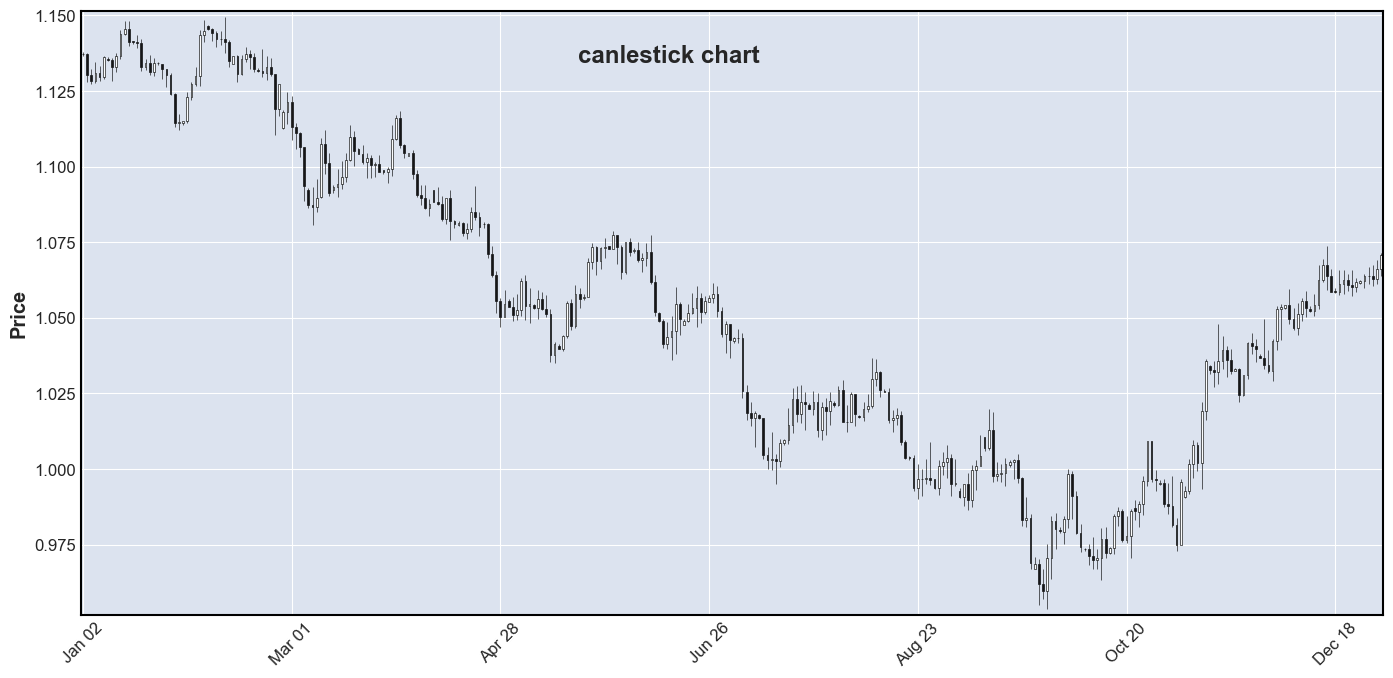

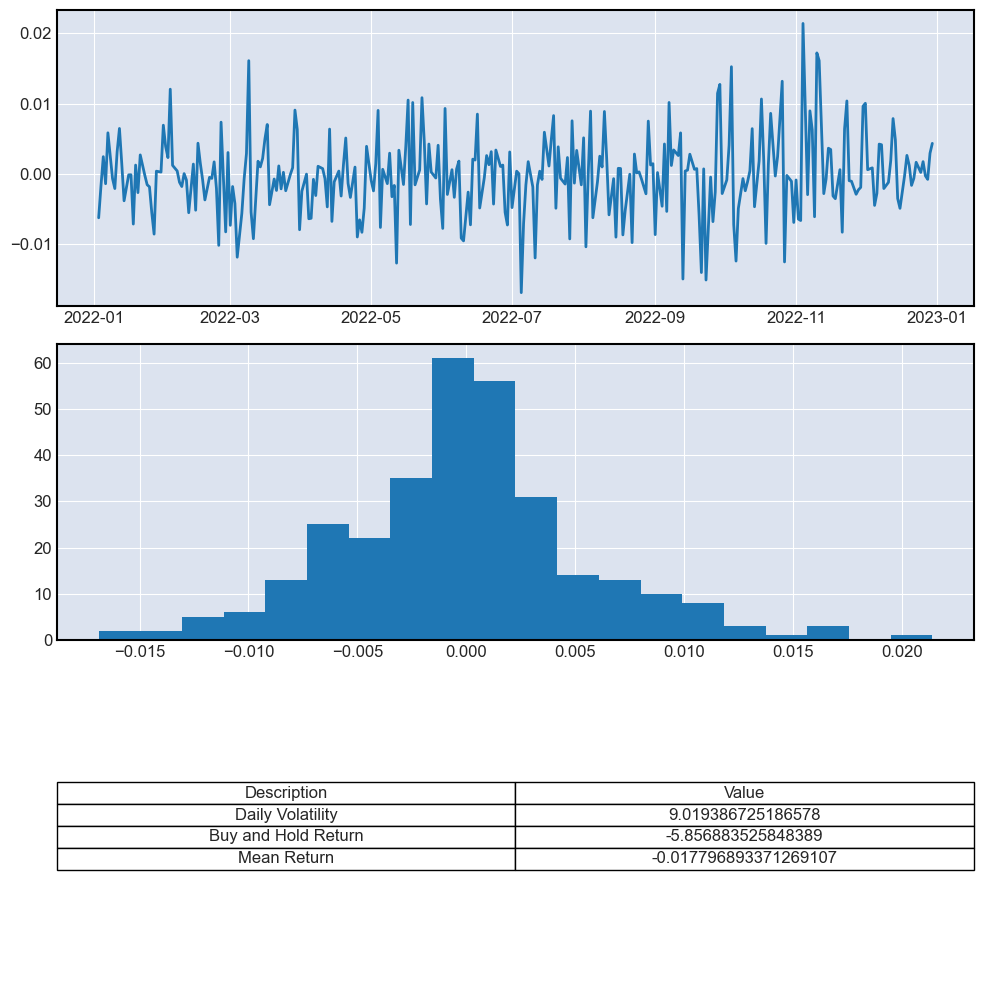

In [12]:
data_analysis_for_bp('Data for Practicum 2/ticks_2022.pkl')

## Ladder strategy data engineering and strategy visualisation

In [13]:
def ladderize_open(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    ladderized_data = [tick_data.iloc[0]]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price
    ladderized_data[-1]=tick_data.iloc[-1]
    return pd.Series(np.round(ladderized_data,4), index=tick_data.index)

In [14]:
def ladderize_absolute(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    # Initialize ladder at the nearest rounded price level based on grid size
    ladderized_data = [(tick_data.iloc[0] / grid_size).round() * grid_size]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price and changing th open price
    ladderized_data[-1]=tick_data.iloc[-1]
    ladderized_data[0]=tick_data.iloc[0]
    return pd.Series(np.round(ladderized_data,4), index=tick_data.index)

In [15]:
def plot_colored_ladder(ladderized_data):
    for i in range(1, len(ladderized_data)):
        if ladderized_data[i] > ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='red')
        elif ladderized_data[i] < ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='green')
        else:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='blue')  # Neutral color for no change

In [16]:

def plot_ladderized(start_date, end_date, grid_size=0.0005, ladderize_function=ladderize_open):
    # Load the tick data
    tick_data = dfb.get_tick_data(start_date,end_date)['EURUSD.mid']

    ladderized_data = ladderize_function(tick_data, grid_size)

    # Plot the results
    plt.figure(figsize=(15,6))
    plt.plot(tick_data, label='Tick Data',alpha=0.5)
    plot_colored_ladder(ladderized_data)
    # plt.plot(ladderized_data, label='Ladderized Data', linestyle='--')
    plt.title('Ladder Strategy Visualization for date range: {} to {}'.format(start_date, end_date))
    plt.legend()
    plt.show()



2023-09-17 15:43:21,371 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-17 15:43:21,371 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-17 15:43:21,594 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-02 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/02/00h_ticks.bi5
2023-09-17 15:43:28,142 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-03 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/03/00h_ticks.bi5
2023-09-17 15:43:37,348 - findatapy.market.datavendorweb - INFO - Completed request from Dukascopy
2023-09-17 15:43:37,356 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_858__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_... to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


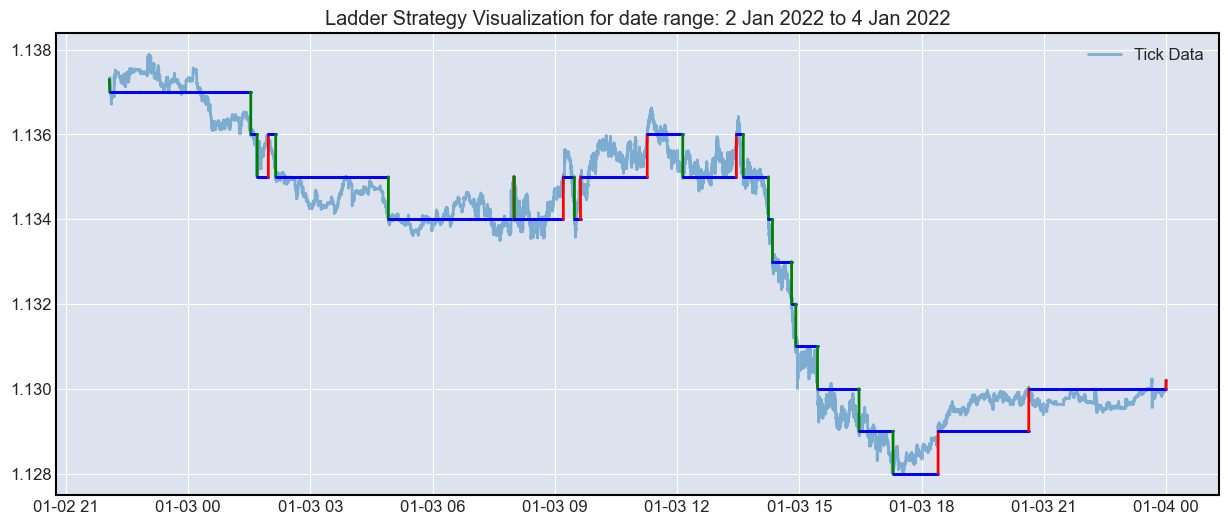

In [17]:
plot_ladderized('2 Jan 2022','4 Jan 2022',grid_size=0.001,ladderize_function=ladderize_absolute)

In [176]:
tick_data = dfb.get_tick_data('2 Jan 2022','8 Jan 2022')['EURUSD.mid']
ladderized_data = ladderize_absolute(tick_data, grid_size=0.001)

2023-09-17 16:58:01,368 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-17 16:58:01,369 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-17 16:58:01,372 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-02 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/02/00h_ticks.bi5
2023-09-17 16:58:06,484 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-03 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/03/00h_ticks.bi5
2023-09-17 16:58:12,880 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-04 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/04/00h_ticks.bi5
2023-09-17 16:58:18,664 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-05 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/05/00h_ticks.bi5
2023-09-17 16:58:24,904 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-06 00:00:00 https://www.dukascopy.com

In [350]:
def filter_jumps(ladderized_data):
    """
    Filters ladderized data to keep only the changes in price.

    :param ladderized_data: A pandas Series of ladderized data.
    :return: A pandas Series containing only the data points where there's a change.
    """
    # Calculate the difference between consecutive ladderized data points
    diff = ladderized_data.diff()

    # Filter where the difference is non-zero and include the first data point
    jumps = ladderized_data[diff != 0.0]

    return jumps


In [351]:
def aggregate_differences(jumps,lot_size=1):
    """
    Aggregate the position for buy/sell signals.

    :param jumps: A pandas Series of ladderized data filtered for jumps.
    :return: A pandas Series representing the aggregated position.
    """
    aggregated_position = [0]  # starting from 0
    position = 0
    previous_value = jumps.values[0]
    
    for value in jumps.values[1:]:
        if value > previous_value:
            position -= lot_size  # selling one lot
        else:
            position += lot_size  # buying one lot
        aggregated_position.append(position)
        previous_value = value
    aggregated_position[-1]=0 # closing the position
    return pd.Series(aggregated_position, index=jumps.index)


In [352]:
def plot_jumps(ladderized_data):
    jumps = filter_jumps(ladderized_data)
    aggregated_diff = aggregate_differences(jumps)
    fig,axs = plt.subplots(2,1,figsize=(10,10))
    # Plotting the jumps
    axs[0].plot(jumps.values, label='binomial jumps', linestyle='--', alpha=0.7)
    axs[0].set_title('ladder with jumps')
    # Adding colored points for up and down movements
    previous_value = jumps.values[0]
    for idx, value in enumerate(jumps.values[1:], 1):
        if idx == len(jumps)-1:
            continue
        elif value > previous_value:
            axs[0].plot(idx, value, 'ro')  # Red point for upward movement
        elif value < previous_value:
            axs[0].plot(idx, value, 'go')  # green point for downward movement
        else:
            axs[0].plot(idx, value, 'bo') # blue point for no change
        previous_value = value
        
        # Add vertical line to all subplots
        for ax in axs:
            ax.axvline(idx, alpha=0.5, color='gray')
            
            
    axs[0].legend()
    # Plotting the aggregated differences
    axs[1].plot(aggregated_diff.values, label='position', linestyle='-', color='purple', alpha=0.8, drawstyle='steps-post')
    axs[1].legend()
    axs[1].set_title('positions')
    plt.show()

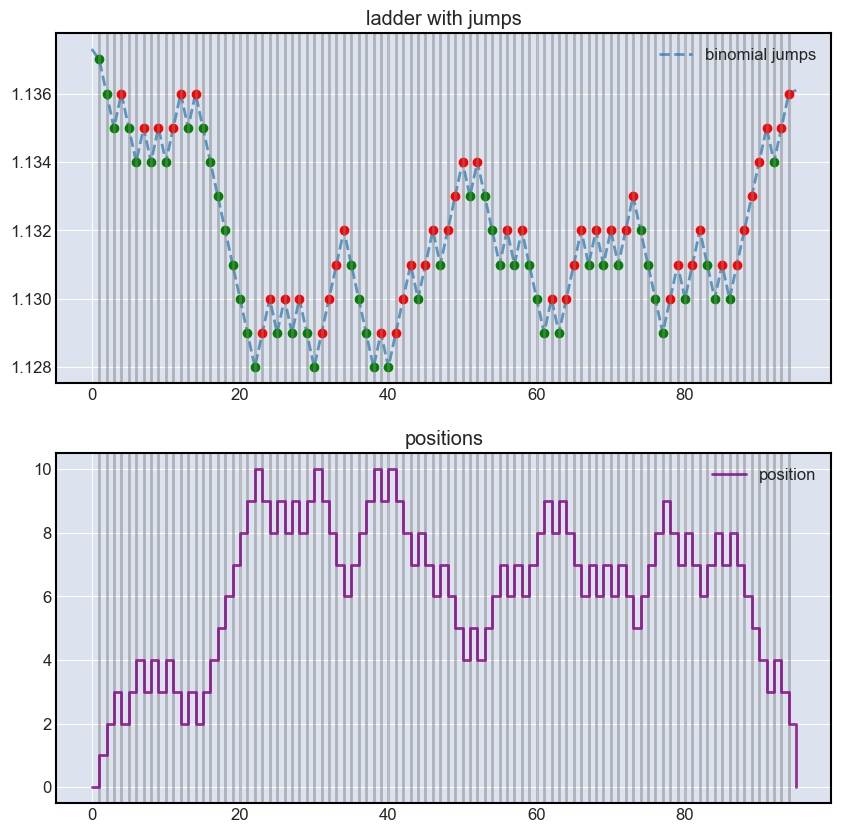

In [353]:
plot_jumps(ladderized_data)

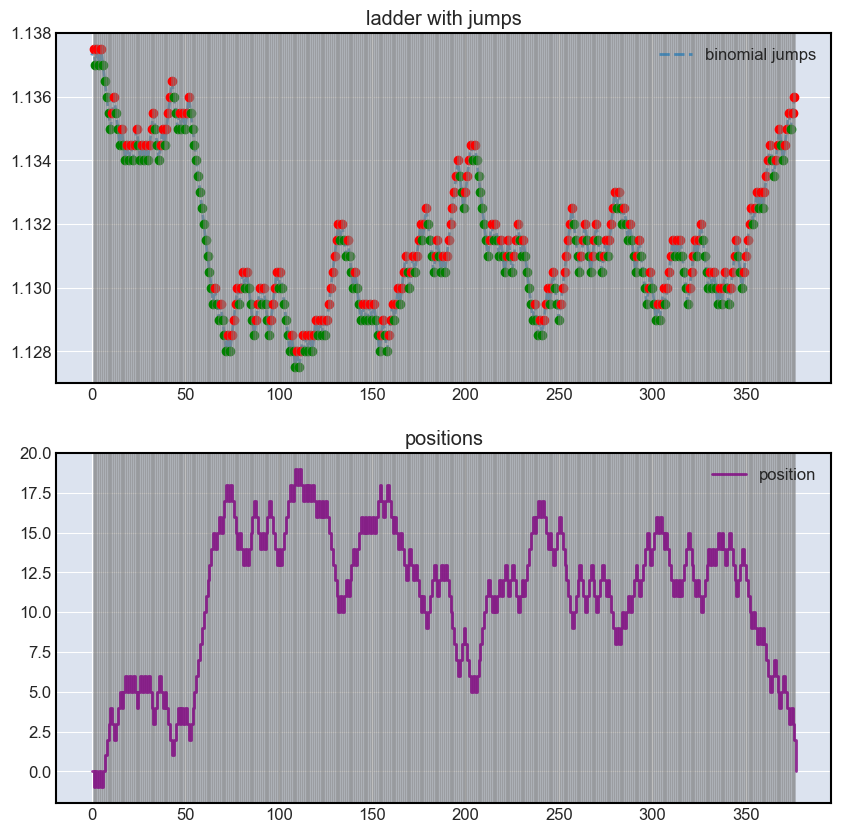

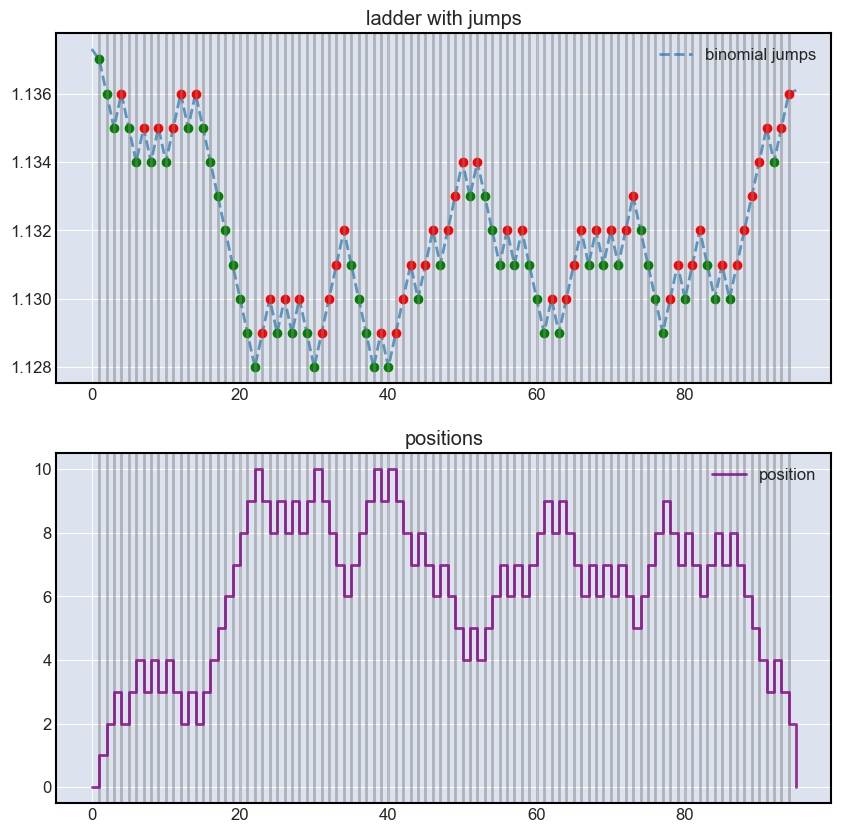

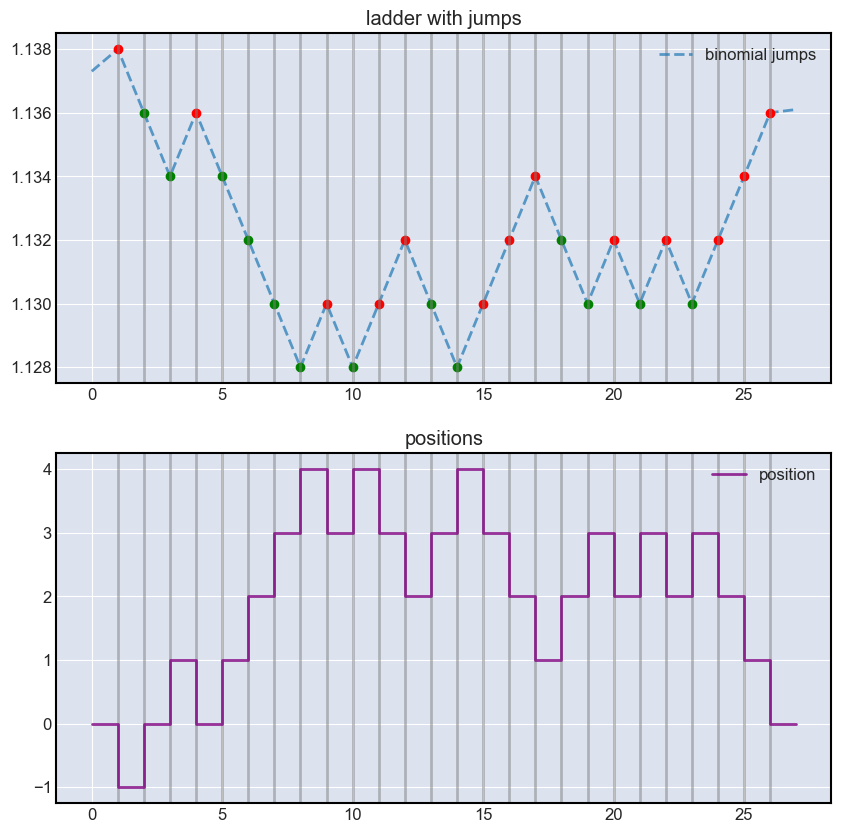

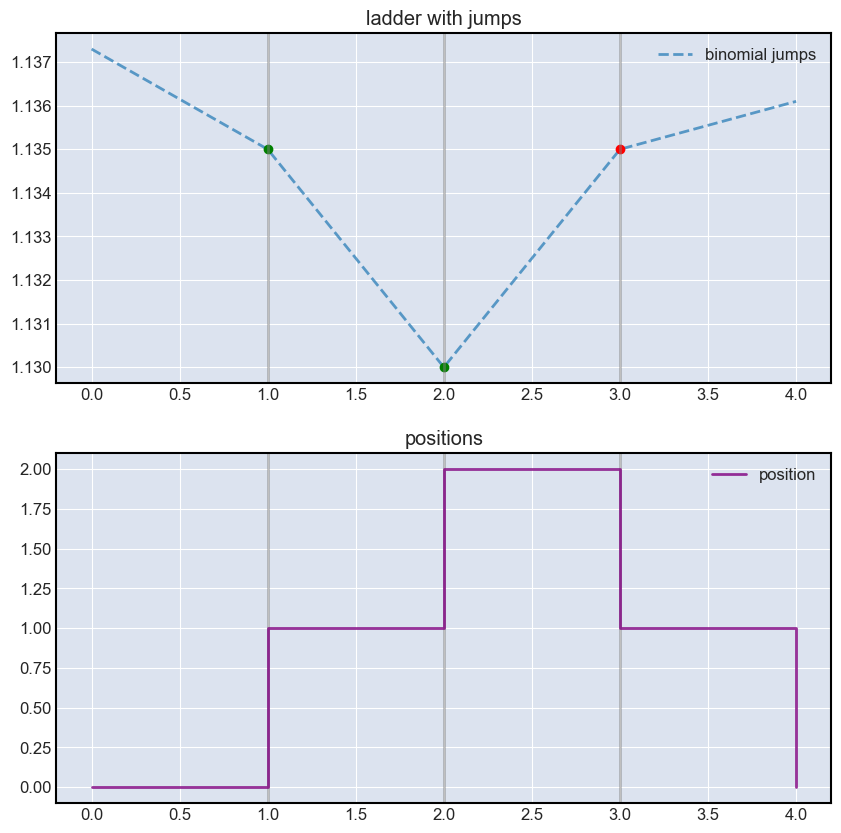

In [354]:
for grid_sizing in [0.0005, 0.001, 0.002, 0.005]:
    ladderised_data = ladderize_absolute(tick_data, grid_size=grid_sizing)
    plot_jumps(ladderised_data)

In [355]:
def velocity(data,grid_sizing):
    return np.round(5*data.diff()/(data)/grid_sizing,1)

def acceleration(data,grid_sizing):
    return np.round(5*data.diff().diff()/(data)/grid_sizing,1)

In [356]:
jumps = filter_jumps(ladderized_data)
jump_ema = jumps.ewm(span=10).mean()

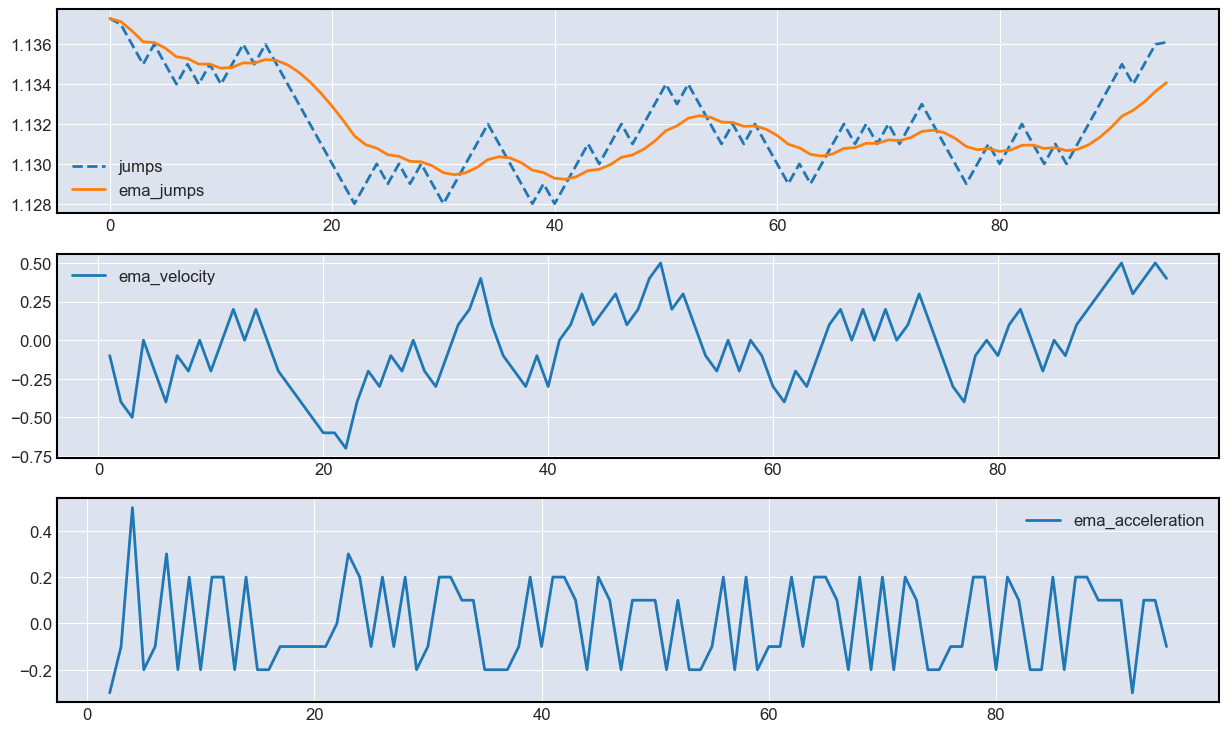

In [357]:
# Plot the results
fig,axs = plt.subplots(3,1,figsize=(15,9))
axs[0].plot(jumps.values, label='jumps', linestyle='--')
axs[0].plot(jump_ema.values, label='ema_jumps', linestyle='-')
#axs[0].plot(ladderized_data, label='Ladderized Data',alpha=0.5)
axs[0].legend()
axs[1].plot(velocity(jump_ema,grid_sizing).values, label='ema_velocity')
axs[1].legend()
axs[2].plot(acceleration(jump_ema,grid_sizing).values, label='ema_acceleration')
axs[2].legend()
plt.show() 

In [358]:
def convert_to_grid_binomial_data(tick_data,grid_size,ladderized_function):
    ladderized_data = ladderized_function(tick_data,grid_size)
    jumps = filter_jumps(ladderized_data)
    binomial_data = jumps.diff()
    binomial_data[1:] = np.where(binomial_data[1:] > 0,1,-1)
    binomial_data[0] = 0
    return jumps,binomial_data

In [359]:
grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,0.0005,ladderize_absolute)

## Strategy

In [360]:
start_date = '2 jan 2022'
end_date = '8 jan 2022'
tick_data = dfb.get_tick_data(start_date,end_date)['EURUSD.mid']

2023-09-17 17:49:11,023 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-17 17:49:11,025 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-17 17:49:11,033 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-02 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/02/00h_ticks.bi5
2023-09-17 17:49:15,724 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-03 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/03/00h_ticks.bi5
2023-09-17 17:49:20,887 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-04 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/04/00h_ticks.bi5
2023-09-17 17:49:26,145 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-05 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2022/00/05/00h_ticks.bi5
2023-09-17 17:49:31,291 - findatapy.market.datavendorweb - INFO - Downloading... 2022-01-06 00:00:00 https://www.dukascopy.com

In [391]:
grid_sizing = 0.001
lot_sizing = 1000000
grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladderize_absolute)

In [392]:
def build_lot_sizing(lot_sizing,binomial_data,multiplier=1,indicator_data=[]):
    T = len(binomial_data)
    if len(indicator_data) == 0: # No indicator data
        return [lot_sizing * (multiplier**i) for i in range(T)]
    else: # Indicator data is present
        scaling_criteria =  binomial_data * indicator_data  # +ve if both are same sign hence signifies movement in same direction , we do not scale in that case
        positions = np.where(scaling_criteria > 0,1,1+abs(scaling_criteria))*lot_sizing # +ve if both are same sign hence signifies movement in same direction , we do not scale in that case
        positions[np.isnan(positions)] = 0
        return positions

In [405]:
def indicator_prep(data,grid_sizing):
    data = velocity(data.ewm(span=10).mean(),grid_sizing).shift(1) # we shift this because our lot sizing will be decided by what the values are prior not current
    data[np.isnan(data)] = 0
    return data

In [406]:
indicator_data = indicator_prep(grid_jumps,grid_sizing)

In [407]:
indicator_data

Date
2022-01-02 22:03:54.650000+00:00    0.0
2022-01-02 22:04:28.267000+00:00    0.0
2022-01-03 01:32:10.880000+00:00   -0.7
2022-01-03 01:41:38.574000+00:00   -2.0
2022-01-03 01:58:00.013000+00:00   -2.4
                                   ... 
2022-01-07 16:04:53.543000+00:00    2.1
2022-01-07 16:19:04.883000+00:00    2.6
2022-01-07 16:41:14.505000+00:00    1.3
2022-01-07 18:37:07.597000+00:00    1.9
2022-01-07 21:59:59.501000+00:00    2.3
Length: 96, dtype: float64

In [408]:
position_data = build_lot_sizing(lot_sizing,binomial_data,multiplier=1,indicator_data=indicator_data)

In [409]:
position_data

array([1000000., 1000000., 1000000., 1000000., 3400000., 1000000.,
       1000000., 2900000., 1000000., 2200000., 1000000., 1900000.,
       1000000., 2000000., 1100000., 1800000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000., 1000000., 4400000.,
       2900000., 1000000., 2400000., 1000000., 2100000., 1000000.,
       1000000., 2500000., 1400000., 1000000., 1000000., 2800000.,
       1600000., 1000000., 1000000., 2700000., 1000000., 2300000.,
       1200000., 1000000., 2300000., 1000000., 1000000., 2600000.,
       1000000., 1000000., 1000000., 3300000., 1000000., 2700000.,
       1600000., 1000000., 2100000., 1000000., 1900000., 1100000.,
       1000000., 1000000., 2900000., 1000000., 2500000., 1400000.,
       1000000., 2200000., 1000000., 2000000., 1000000., 1800000.,
       1200000., 1000000., 2400000., 1300000., 1000000., 1000000.,
       2800000., 1700000., 1200000., 1600000., 1000000., 2100000.,
       1100000., 1800000., 1200000., 1700000., 1000000., 10000

In [397]:
def plot_trades(grid_jumps,PNL,N,lookback=10):
    fig,axs = plt.subplots(3,1,figsize=(15,15))
    axs[0].plot(grid_jumps.values, label='jumps', linestyle='--')
    axs[0].plot(grid_jumps.ewm(span=lookback).mean().values, label='indicator', linestyle='-',alpha=0.6)
    for idx, i in enumerate(grid_jumps):
        if grid_jumps[idx] > grid_jumps[idx-1]:
            axs[0].plot(idx, i, 'ro')  # Red point for upward movement
        elif grid_jumps[idx] < grid_jumps[idx-1]:
            axs[0].plot(idx, i, 'go')  # Green point for downward movement
        else:
            axs[0].plot(idx, i, 'bo')  # Blue point for no change

        # Add vertical line to all subplots
        for ax in axs:
            ax.axvline(idx, alpha=0.2, color='gray')

    axs[0].set_title('buy sell points')
    axs[1].plot(N)
    # change number of digits in y axis
    axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    axs[1].set_title('lots held')
    axs[2].plot(PNL)
    axs[2].set_title('PNL')
    plt.show()


In [416]:
def run_strategy_continuous(tick_data,grid_sizing,lot_sizing,ladder_function=ladderize_absolute,multiplier=1,indicator = False,print_trade_book=False,trade_plot=False):
    grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladder_function)
    lookback = 15
    indicator_data = []
    if indicator:
        indicator_data = indicator_prep(grid_jumps,grid_sizing)
    T = len(binomial_data)
    PNL = np.zeros(T)
    P = np.zeros(T)
    N = np.zeros(T)
    trades = pd.DataFrame(columns=['t','price','Previous_lots','current_lots','position','PNL'])
    position_sizing = build_lot_sizing(lot_sizing,binomial_data,multiplier=multiplier,indicator_data=indicator_data)
    for t in np.arange(0,T):
        N[t] = N[t-1] - position_sizing[t] * binomial_data[t]
        P[t] = N[t] * grid_jumps[t]
        PNL[t] = PNL[t-1] + N[t-1] * (grid_jumps[t] - grid_jumps[t-1])
        PNL[t]=np.round(PNL[t],2)
        if print_trade_book:
            print('t = {}, price={}, Previous_lots = {},  current_lots= {}, position = {}, PNL = {}'.format(t,grid_jumps[t],N[t-1],N[t],P[t],PNL[t]))
        trade = pd.Series({'t':t,'price':grid_jumps[t],'Previous_lots':N[t-1],'current_lots':N[t],'position':P[t],'PNL':PNL[t]})
        trades = pd.concat([trades, trade.to_frame().T])
    if trade_plot:
        plot_trades(grid_jumps,PNL,N,lookback=lookback)
    return PNL,N,P,trades

t = 0, price=1.1373, Previous_lots = 0.0,  current_lots= 0.0, position = 0.0, PNL = 0.0
t = 1, price=1.137, Previous_lots = 0.0,  current_lots= 1000000.0, position = 1137000.0, PNL = 0.0
t = 2, price=1.136, Previous_lots = 1000000.0,  current_lots= 2000000.0, position = 2272000.0, PNL = -1000.0
t = 3, price=1.135, Previous_lots = 2000000.0,  current_lots= 3000000.0, position = 3405000.0, PNL = -3000.0
t = 4, price=1.136, Previous_lots = 3000000.0,  current_lots= 2000000.0, position = 2272000.0, PNL = -0.0
t = 5, price=1.135, Previous_lots = 2000000.0,  current_lots= 3000000.0, position = 3405000.0, PNL = -2000.0
t = 6, price=1.134, Previous_lots = 3000000.0,  current_lots= 4000000.0, position = 4536000.0, PNL = -5000.0
t = 7, price=1.135, Previous_lots = 4000000.0,  current_lots= 3000000.0, position = 3405000.0, PNL = -1000.0
t = 8, price=1.134, Previous_lots = 3000000.0,  current_lots= 4000000.0, position = 4536000.0, PNL = -4000.0
t = 9, price=1.135, Previous_lots = 4000000.0,  curre

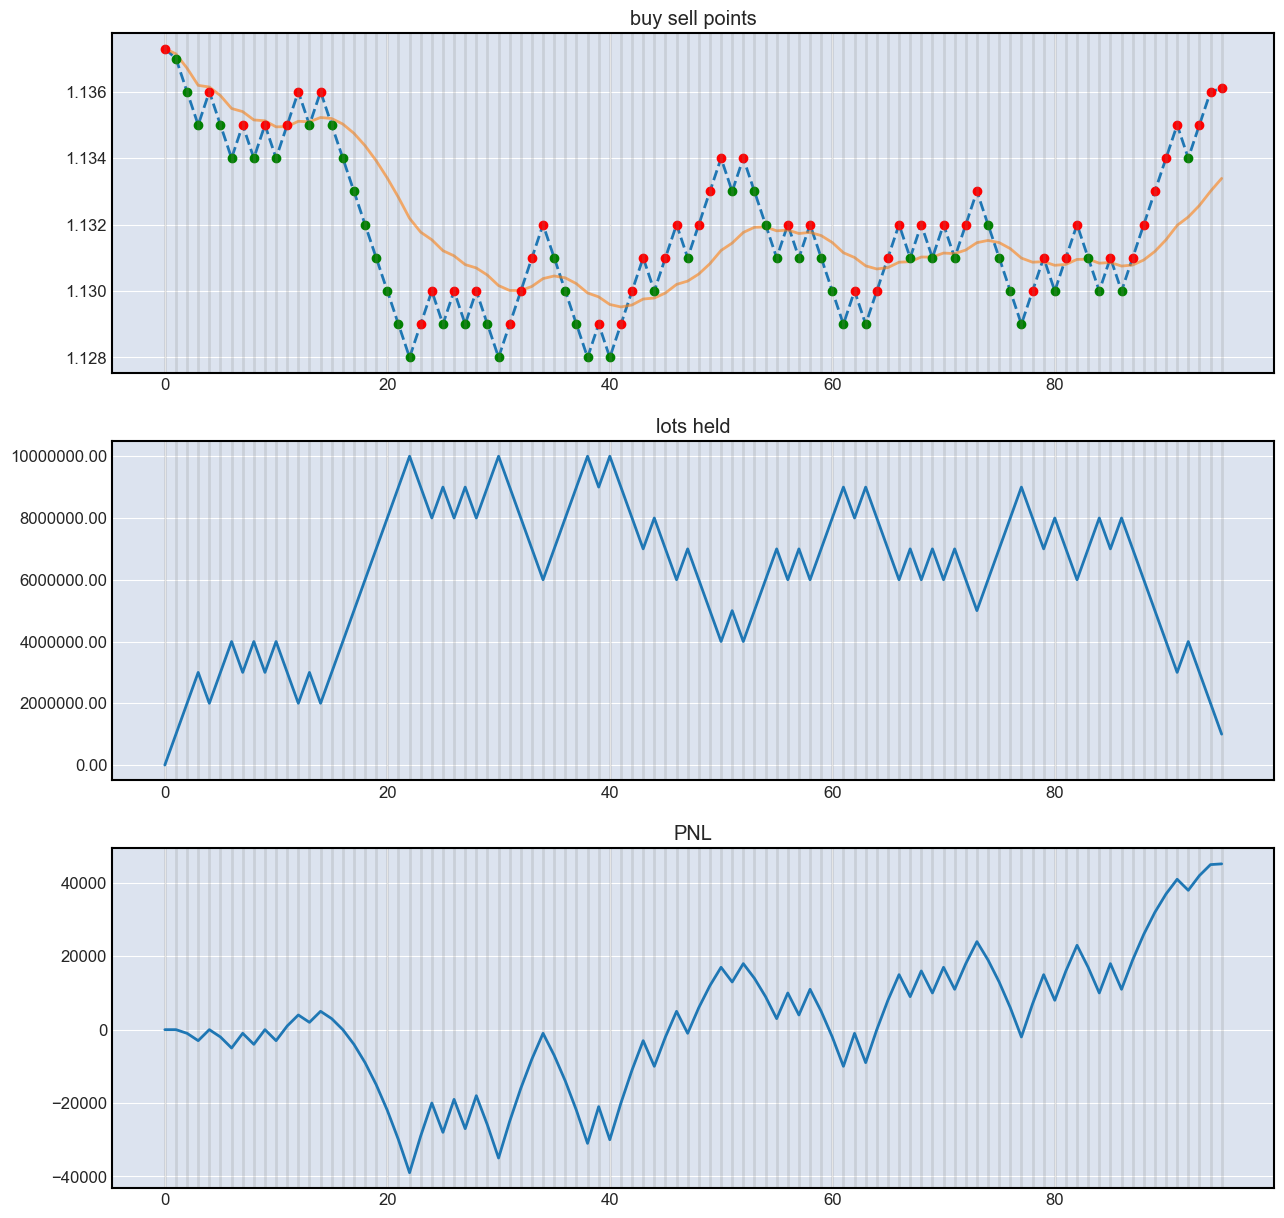

In [417]:
PNL, N, P, trades = run_strategy_continuous(tick_data,grid_sizing,lot_sizing,ladder_function=ladderize_absolute,multiplier=1,indicator = False,print_trade_book=True,trade_plot=True)

In [413]:
trades

,t,price,Previous_lots,current_lots,position,PNL
0,0.0,1.1373,0.0,0.0,0.0,0.0
0,1.0,1.1370,0.0,1000000.0,1137000.0,0.0
0,2.0,1.1360,1000000.0,2000000.0,2272000.0,-1000.0
0,3.0,1.1350,2000000.0,3000000.0,3405000.0,-3000.0
0,4.0,1.1360,3000000.0,2000000.0,2272000.0,-0.0
...,...,...,...,...,...,...
0,91.0,1.1350,4000000.0,3000000.0,3405000.0,41000.0
0,92.0,1.1340,3000000.0,4000000.0,4536000.0,38000.0
0,93.0,1.1350,4000000.0,3000000.0,3405000.0,42000.0
0,94.0,1.1360,3000000.0,2000000.0,2272000.0,45000.0
